<a href="https://colab.research.google.com/github/BakhtawarRehman/ObjectDetection/blob/master/stanford_Cars_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2

Using TensorFlow backend.


In [3]:
!wget http://imagenet.stanford.edu/internal/car196/cars_test.tgz

--2020-02-02 18:33:45--  http://imagenet.stanford.edu/internal/car196/cars_test.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977350468 (932M) [application/x-gzip]
Saving to: ‘cars_test.tgz’

cars_test.tgz       100%[===================>] 932.07M  11.7MB/s    in 90s     

2020-02-02 18:35:15 (10.4 MB/s) - ‘cars_test.tgz’ saved [977350468/977350468]



In [4]:
!wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz

--2020-02-02 18:35:17--  http://imagenet.stanford.edu/internal/car196/cars_train.tgz
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  38.0MB/s    in 76s     

2020-02-02 18:36:34 (12.2 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]



In [0]:
!tar -xf /content/cars_train.tgz    

In [0]:
!tar -xf /content/cars_test.tgz

In [7]:
!wget http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

--2020-02-02 18:36:58--  http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K  --.-KB/s    in 0.1s    

2020-02-02 18:36:58 (2.28 MB/s) - ‘car_devkit.tgz’ saved [330960/330960]



In [0]:
!tar -xf car_devkit.tgz

 **Preprocessing** 

In [0]:
# Colab loads file not based on index or name. SO we need to load them by names to keep record here.
# This is not valid here
#train = [mpimg.imread(file) for file in glob.glob('./cars_train/*.jpg')]
#test = [mpimg.imread(file) for file in glob.glob('./cars_test/*.jpg')]

**##  Reading labels in numpy - python :)**

In [0]:
import scipy.io
labelsTr = scipy.io.loadmat('./devkit/cars_train_annos.mat')
labelsTs = scipy.io.loadmat('./devkit/cars_test_annos.mat')

In [10]:
labelsTr.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [11]:
lb = scipy.io.loadmat('./devkit/cars_meta.mat')
lb.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [12]:
print(type(labelsTr['annotations']), labelsTr['annotations'].shape)
print(type(labelsTs['annotations'][0][0]), labelsTs['annotations'][0][0].shape)

<class 'numpy.ndarray'> (1, 8144)
<class 'numpy.void'> ()


In [0]:
dataTr = [[row.flat[0] for row in line] for line in labelsTr['annotations'][0]]
dataTs = [[row.flat[0] for row in line] for line in labelsTs['annotations'][0]]

In [0]:
class_names = [[row.flat[0] for row in line] for line in lb['class_names'][0]]

In [0]:
labelsTr = [i[4] for i in dataTr]

In [0]:
imageNames = [i[5] for i in dataTr]

In [17]:
print(len(labelsTr))
lt=set(labelsTr)
print(len(set(lt))) # unique values # labels

8144
196


In [0]:
#trainImages = [mpimg.imread(file) for file in glob.iglob('./cars_train/'+ imageNames[0], recursive=True)]
# reading images
i=0
trainImages=[]
for image in range(0, 8144):
  trainImages.append(mpimg.imread('./cars_train/' + str(imageNames[i])))
  i+=1


In [19]:
# reshaping images to 224*224 size
trainImages = [cv2.resize(image, (224, 224)) for image in trainImages]

# some images are 2 dimensionals
# We can drop them but it is better toextend them to 3dimensionals and use them for our project.
i = 0
for image in trainImages:
  if len(image.shape) != 3:
    trainImages[i] = np.squeeze(image)
    trainImages[i] = np.repeat(image[..., np.newaxis],3,-1)
  else:
    pass
  i+=1

trainImages = np.array(trainImages)
print(trainImages.shape)

(8144, 224, 224, 3)


In [0]:
labelsTr= [i-1 for i in labelsTr]

In [21]:
labTr = np.array(labelsTr, dtype='int64')

#Converting labels into categorical
labTr = np_utils.to_categorical(labTr)

print(labTr.shape)


(8144, 196)


In [22]:
print(type(labTr))
print(type(trainImages))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<function matplotlib.pyplot.show>

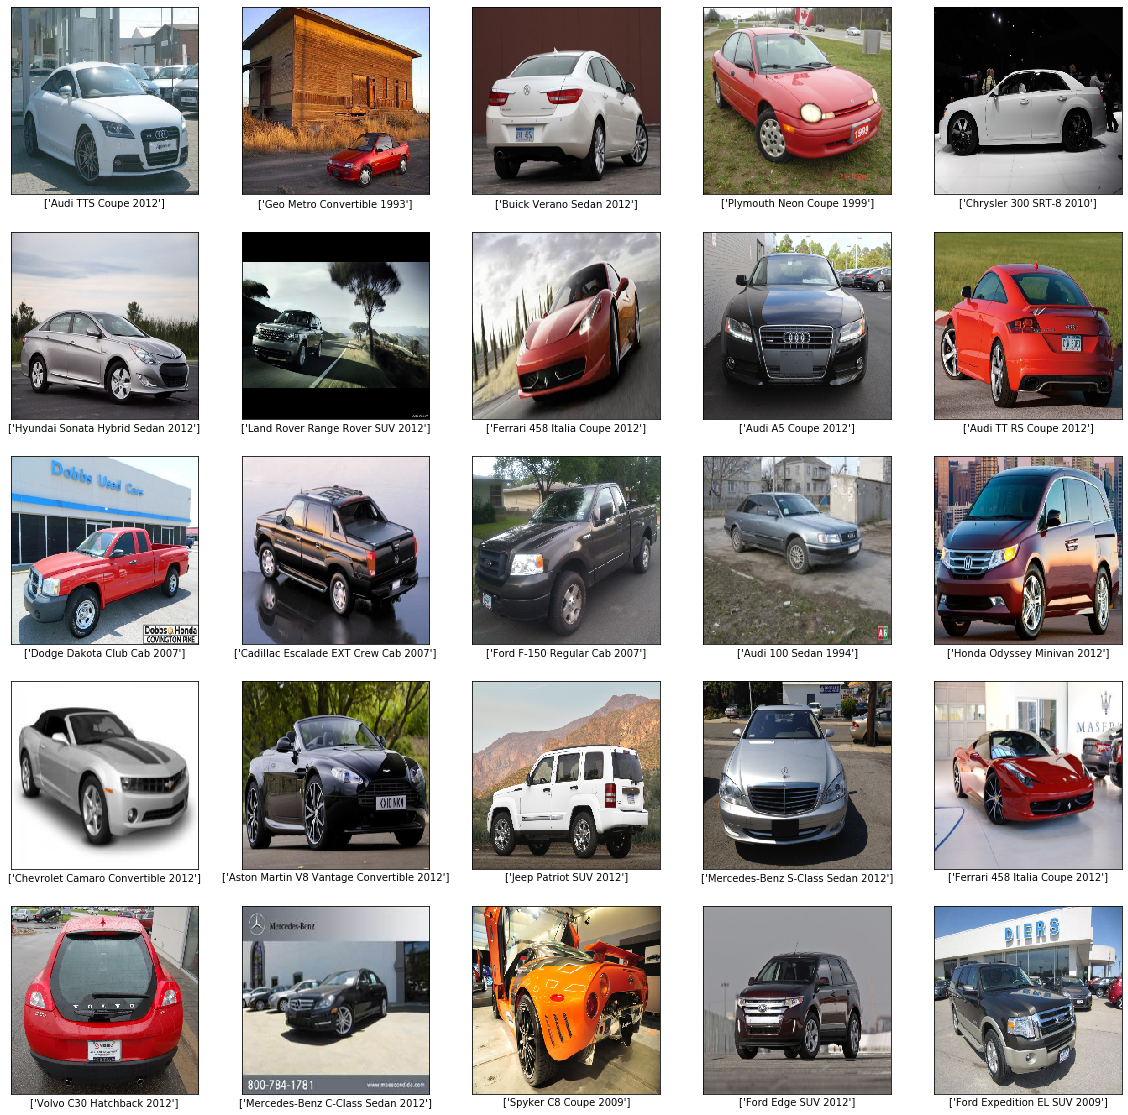

In [23]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    plt.imshow(trainImages[i*5])
    plt.xlabel(class_names[np.argmax(labTr[i*5])])
plt.show

**## Model Defining and Traning**

In [0]:
x_train, x_test, y_train, y_test = train_test_split(trainImages, labTr, test_size=0.15, random_state=2)

In [0]:
#defining our model
model = keras.Sequential([
                          keras.layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),

                          keras.layers.Dropout(0.3),

                          keras.layers.Conv2D(32, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Conv2D(128, kernel_size=(5, 5), activation='relu'),
                          keras.layers.MaxPooling2D(pool_size=(2, 2)),
                          keras.layers.Dropout(0.4),

                          keras.layers.Flatten(),
                          keras.layers.BatchNormalization(),
                          keras.layers.Dense(256, activation='relu'),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(64, activation='relu'),
                          keras.layers.Dense(196, activation='softmax')


])

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   #vertical_flip=True,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
test_datagen = ImageDataGenerator(rescale=1/255.)

In [28]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1,  validation_data=(x_test, y_test), shuffle=True)

Train on 6922 samples, validate on 1222 samples
Epoch 1/50
6922/6922 [==============================] - 11s 2ms/sample - loss: 5.3201 - accuracy: 0.0062 - val_loss: 5.2774 - val_accuracy: 0.0033
Epoch 2/50
6922/6922 [==============================] - 3s 383us/sample - loss: 5.2797 - accuracy: 0.0065 - val_loss: 5.2860 - val_accuracy: 0.0049
Epoch 3/50
6922/6922 [==============================] - 3s 384us/sample - loss: 5.2636 - accuracy: 0.0079 - val_loss: 5.4414 - val_accuracy: 8.1833e-04
Epoch 4/50
6922/6922 [==============================] - 3s 382us/sample - loss: 5.2218 - accuracy: 0.0103 - val_loss: 5.2490 - val_accuracy: 0.0065
Epoch 5/50
6922/6922 [==============================] - 3s 383us/sample - loss: 5.1578 - accuracy: 0.0117 - val_loss: 5.1847 - val_accuracy: 0.0115
Epoch 6/50
6922/6922 [==============================] - 3s 383us/sample - loss: 5.1092 - accuracy: 0.0136 - val_loss: 5.1302 - val_accuracy: 0.0147
Epoch 7/50
6922/6922 [==============================] - 3s 38

In [28]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=128), epochs=20,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // 128,
                 
                 validation_data=test_datagen.flow(x_test, y_test),
                 verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 54 steps, validate for 39 steps
Epoch 1/20
54/54 [==============================] - 73s 1s/step - loss: 5.3310 - accuracy: 0.0031 - val_loss: 5.2792 - val_accuracy: 0.0049
Epoch 2/20
54/54 [==============================] - 72s 1s/step - loss: 5.2806 - accuracy: 0.0056 - val_loss: 5.2730 - val_accuracy: 0.0057
Epoch 3/20
54/54 [==============================] - 70s 1s/step - loss: 5.2651 - accuracy: 0.0065 - val_loss: 5.2974 - val_accuracy: 0.0041
Epoch 4/20
54/54 [==============================] - 70s 1s/step - loss: 5.2321 - accuracy: 0.0071 - val_loss: 5.5539 - val_accuracy: 0.0016
Epoch 5/20
54/54 [==============================] - 71s 1s/step - loss: 5.1943 - accuracy: 0.0115 - val_loss: 5.8275 - val_accuracy: 0.0033
Epoch 6/20
54/54 [==============================] - 70s 1s/step - loss: 5.1697 - accuracy: 0.0130 - val_loss: 5.2558 - val_accuracy:

Using transfer learning - Inception V3

In [27]:
#google drive to load files from
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
local_weights_file = "/content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (224,224,3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [29]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x=keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = keras.layers.Dropout(0.4)(x)     

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)   

# Add a final sigmoid layer for classification
x = keras.layers.Dense  (196, activation='softmax')(x)           

model = keras.models.Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [34]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1,  validation_data=(x_test, y_test), shuffle=True)

Train on 6922 samples, validate on 1222 samples
Epoch 1/50
6922/6922 [==============================] - 15s 2ms/sample - loss: 6.8345 - acc: 0.0052 - val_loss: 5.2786 - val_acc: 0.0041
Epoch 2/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 5.2623 - acc: 0.0116 - val_loss: 5.2792 - val_acc: 0.0033
Epoch 3/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 5.1792 - acc: 0.0220 - val_loss: 5.2798 - val_acc: 0.0033
Epoch 4/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 5.0928 - acc: 0.0283 - val_loss: 5.2803 - val_acc: 0.0106
Epoch 5/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 5.0397 - acc: 0.0379 - val_loss: 5.2809 - val_acc: 0.0106
Epoch 6/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 4.9567 - acc: 0.0455 - val_loss: 5.2816 - val_acc: 0.0025
Epoch 7/50
6922/6922 [==============================] - 10s 1ms/sample - loss: 4.9119 - acc: 0.0504 - val_loss: 5.2822 - val_acc: 

In [31]:
# run model
hist = model.fit_generator( train_datagen.flow(x_train, y_train, batch_size=64), epochs=80,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // 64,
                 
                 validation_data=test_datagen.flow(x_test, y_test),
                 verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 108 steps, validate for 39 steps
Epoch 1/80
108/108 [==============================] - 84s 776ms/step - loss: 7.0107 - acc: 0.0066 - val_loss: 5.2777 - val_acc: 0.0033
Epoch 2/80
108/108 [==============================] - 76s 701ms/step - loss: 5.3146 - acc: 0.0064 - val_loss: 5.2786 - val_acc: 0.0115
Epoch 3/80
108/108 [==============================] - 75s 691ms/step - loss: 5.3054 - acc: 0.0087 - val_loss: 5.2804 - val_acc: 0.0106
Epoch 4/80
108/108 [==============================] - 74s 689ms/step - loss: 5.2890 - acc: 0.0079 - val_loss: 5.2809 - val_acc: 0.0106
Epoch 5/80
108/108 [==============================] - 75s 693ms/step - loss: 5.2771 - acc: 0.0083 - val_loss: 5.2778 - val_acc: 0.0115
Epoch 6/80
108/108 [==============================] - 74s 689ms/step - loss: 5.2854 - acc: 0.0080 - val_loss: 5.2810 - val_acc: 0.0115
Epoch 7/80
108/108 [=

1222/1222 - 0s - loss: 917.6823 - accuracy: 0.0057


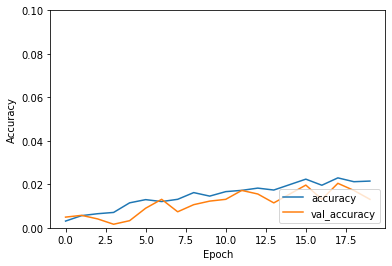

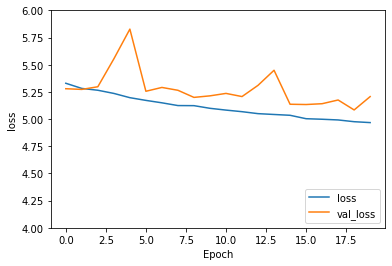

<Figure size 432x288 with 0 Axes>

In [31]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.1])
plt.legend(loc='lower right')
plt.figure()


plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([4, 6])
plt.legend(loc='lower right')
plt.figure()

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)